In [5]:
%%writefile data_loader.py
"""
Модуль загрузки данных из CSV-файла.
Содержит функцию load_data, которая читает файл и возвращает DataFrame.
"""
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path, parse_dates=['date'])
        logging.info(f"Данные успешно загружены из {file_path}. Размер: {df.shape}")
        return df
    except FileNotFoundError:
        logging.error(f"Файл не найден: {file_path}")
        raise
    except pd.errors.EmptyDataError:
        logging.error(f"Файл пуст: {file_path}")
        raise
    except Exception as e:
        logging.error(f"Ошибка при загрузке данных: {e}")
        raise

if __name__ == "__main__":
    data = load_data("sales_data.csv")
    print(data.head())

Overwriting data_loader.py


In [6]:
"""
Модуль обработки и агрегации данных.
Содержит функции для очистки, фильтрации и группировки данных.
"""
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Очищает данные: удаляет дубликаты, пропуски и приводит типы.

    Параметры:
        df (pd.DataFrame): исходный DataFrame.

    Возвращает:
        pd.DataFrame: очищенный DataFrame.
    """
    initial_shape = df.shape
    # Удаление дубликатов
    df = df.drop_duplicates()
    # Удаление строк с пропущенными значениями
    df = df.dropna()
    # Приведение sales и profit к числовому типу (если ещё не числа)
    for col in ['sales', 'profit']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # После преобразования снова удаляем строки с NaN (если появились)
    df = df.dropna(subset=['sales', 'profit'])
    logging.info(f"Очистка данных: было {initial_shape}, стало {df.shape}")
    return df


def aggregate_sales_by_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Группирует данные по категориям, суммируя продажи и прибыль.

    Параметры:
        df (pd.DataFrame): очищенный DataFrame.

    Возвращает:
        pd.DataFrame: агрегированные данные.
    """
    grouped = df.groupby('category', as_index=False).agg({
        'sales': 'sum',
        'profit': 'sum'
    })
    grouped = grouped.sort_values('sales', ascending=False)
    logging.info(f"Агрегация по категориям выполнена. Категорий: {len(grouped)}")
    return grouped


def filter_by_date(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Фильтрует данные по диапазону дат.

    Параметры:
        df (pd.DataFrame): DataFrame с колонкой 'date' (datetime).
        start_date (str): начальная дата в формате YYYY-MM-DD.
        end_date (str): конечная дата в формате YYYY-MM-DD.

    Возвращает:
        pd.DataFrame: отфильтрованный DataFrame.
    """
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    filtered = df.loc[mask]
    logging.info(f"Фильтр по датам: с {start_date} по {end_date}, осталось записей: {len(filtered)}")
    return filtered


if __name__ == "__main__":
    # Пример тестирования модуля
    sample_data = pd.DataFrame({
        'date': ['2023-01-01', '2023-01-02', '2023-01-01'],
        'product': ['A', 'B', 'A'],
        'category': ['Electronics', 'Clothing', 'Electronics'],
        'sales': [100, 200, 150],
        'profit': [20, 30, 25]
    })
    sample_data['date'] = pd.to_datetime(sample_data['date'])
    cleaned = clean_data(sample_data)
    print("Очищенные данные:\n", cleaned)
    aggregated = aggregate_sales_by_category(cleaned)
    print("Агрегация по категориям:\n", aggregated)
    filtered = filter_by_date(cleaned, '2023-01-01', '2023-01-01')
    print("Фильтр по дате 2023-01-01:\n", filtered)

Очищенные данные:
         date product     category  sales  profit
0 2023-01-01       A  Electronics    100      20
1 2023-01-02       B     Clothing    200      30
2 2023-01-01       A  Electronics    150      25
Агрегация по категориям:
       category  sales  profit
1  Electronics    250      45
0     Clothing    200      30
Фильтр по дате 2023-01-01:
         date product     category  sales  profit
0 2023-01-01       A  Electronics    100      20
2 2023-01-01       A  Electronics    150      25


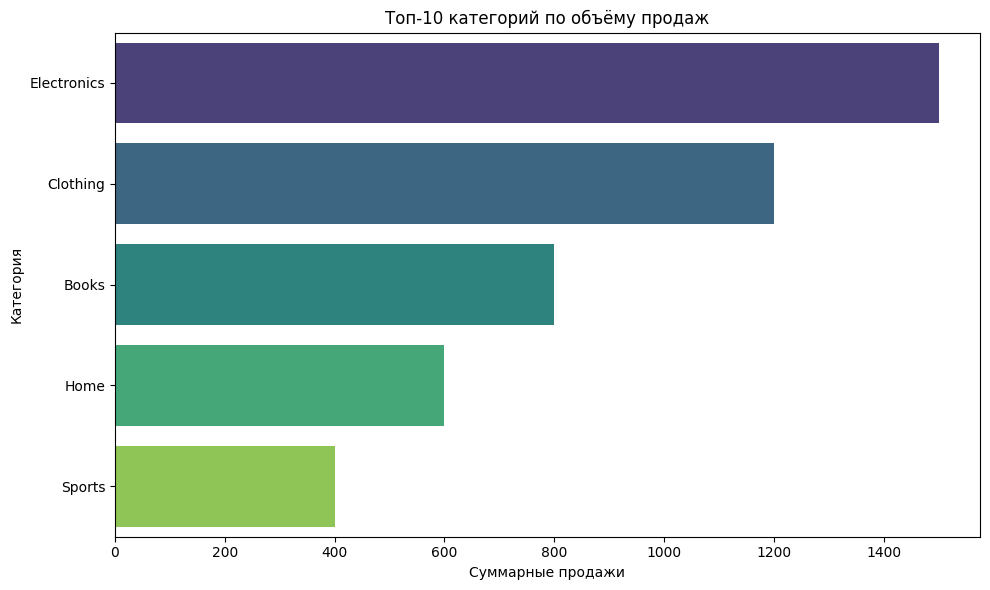

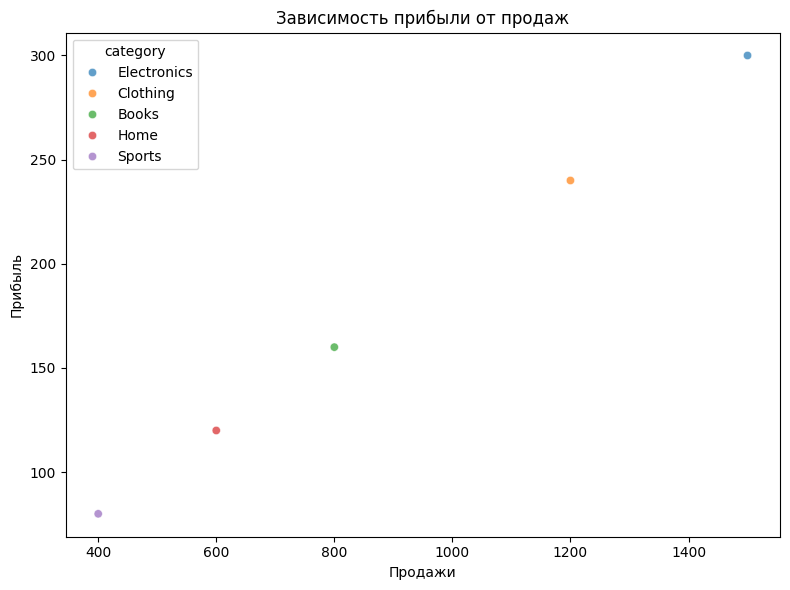

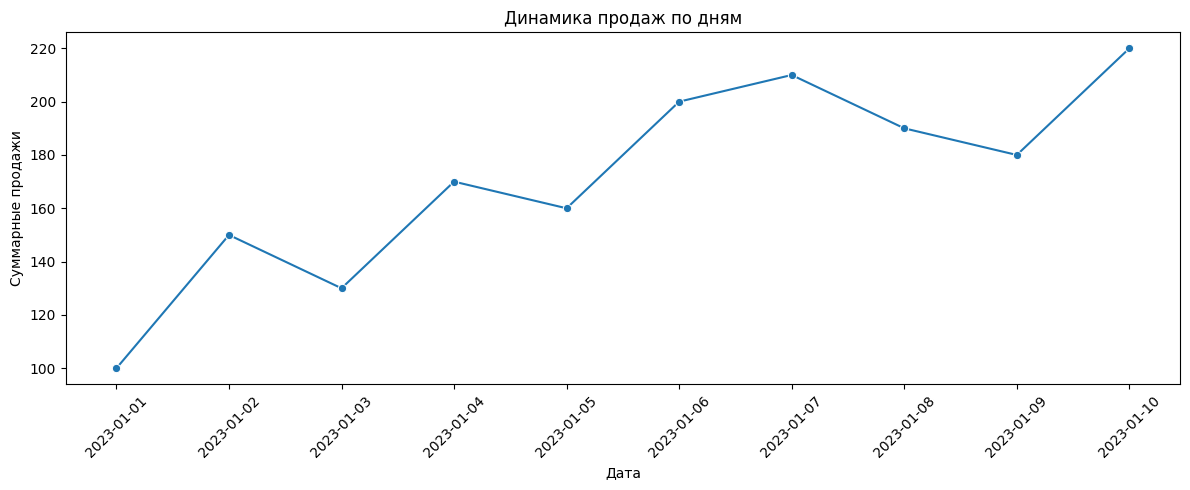

In [7]:
"""
Модуль визуализации данных.
Содержит функции для построения графиков на основе DataFrame.
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def plot_sales_by_category(df: pd.DataFrame, top_n: int = 10) -> None:
    """
    Строит столбчатую диаграмму продаж по категориям (топ-N).
    """
    df_sorted = df.sort_values('sales', ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_sorted, x='sales', y='category',
            hue='category', palette='viridis', legend=False)
    plt.title(f'Топ-{top_n} категорий по объёму продаж')
    plt.xlabel('Суммарные продажи')
    plt.ylabel('Категория')
    plt.tight_layout()
    logging.info(f"Построен график продаж по категориям (топ-{top_n})")
    plt.show()


def plot_profit_vs_sales_scatter(df: pd.DataFrame) -> None:
    """
    Строит точечную диаграмму зависимости прибыли от продаж.

    Параметры:
        df (pd.DataFrame): исходный или агрегированный DataFrame с колонками 'sales' и 'profit'.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='sales', y='profit', hue='category' if 'category' in df.columns else None, alpha=0.7)
    plt.title('Зависимость прибыли от продаж')
    plt.xlabel('Продажи')
    plt.ylabel('Прибыль')
    plt.tight_layout()
    logging.info("Построен scatter plot прибыли от продаж")
    plt.show()


def plot_sales_timeline(df: pd.DataFrame) -> None:
    """
    Строит временной ряд суммарных продаж по дням.

    Параметры:
        df (pd.DataFrame): исходный DataFrame с колонками 'date' и 'sales'.
    """
    # Группировка по датам, суммирование продаж
    daily_sales = df.groupby('date')['sales'].sum().reset_index()
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=daily_sales, x='date', y='sales', marker='o')
    plt.title('Динамика продаж по дням')
    plt.xlabel('Дата')
    plt.ylabel('Суммарные продажи')
    plt.xticks(rotation=45)
    plt.tight_layout()
    logging.info("Построен временной ряд продаж")
    plt.show()


if __name__ == "__main__":
    # Пример тестирования модуля
    sample_agg = pd.DataFrame({
        'category': ['Electronics', 'Clothing', 'Books', 'Home', 'Sports'],
        'sales': [1500, 1200, 800, 600, 400],
        'profit': [300, 240, 160, 120, 80]
    })
    plot_sales_by_category(sample_agg)
    plot_profit_vs_sales_scatter(sample_agg)

    sample_timeline = pd.DataFrame({
        'date': pd.date_range('2023-01-01', periods=10),
        'sales': [100, 150, 130, 170, 160, 200, 210, 190, 180, 220]
    })
    plot_sales_timeline(sample_timeline)

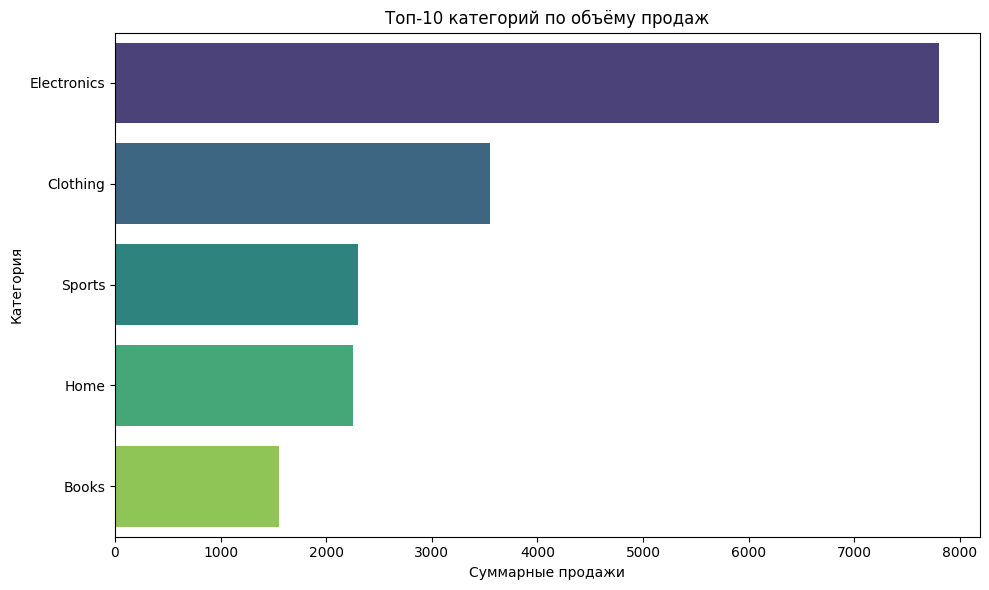

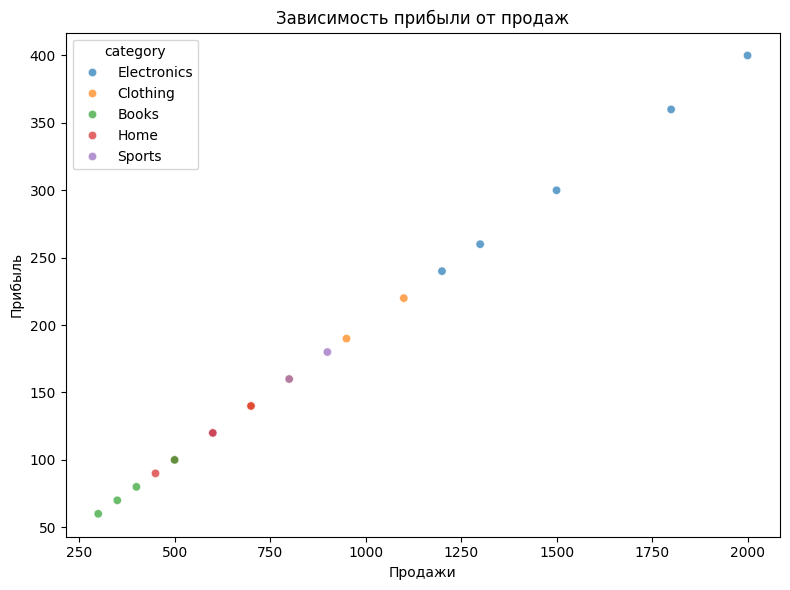

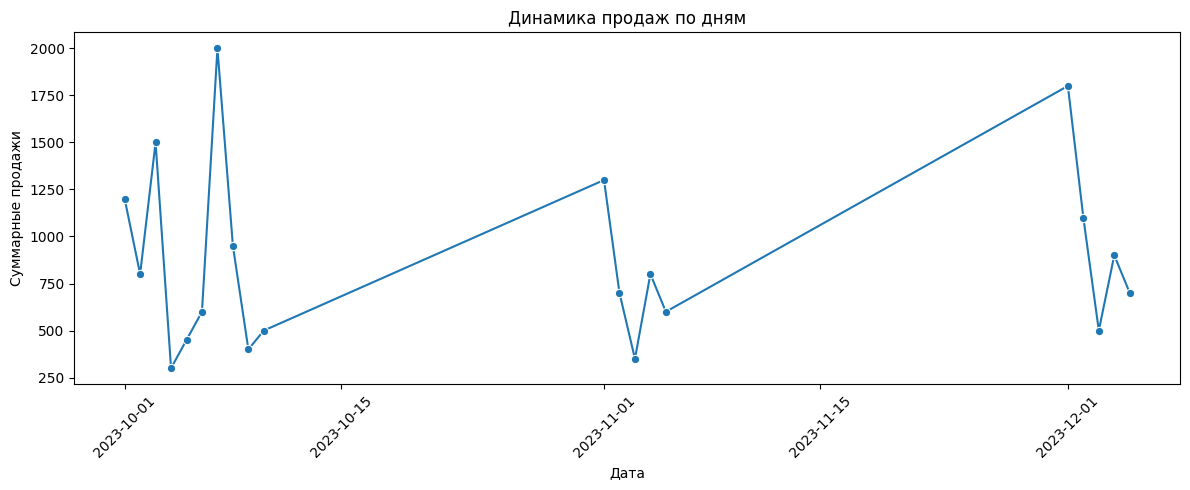

In [8]:
"""
Основной модуль проекта.
Загружает данные, обрабатывает и строит визуализации.
"""
import logging
from data_loader import load_data
from data_processer import clean_data, aggregate_sales_by_category, filter_by_date
from visualisation import plot_sales_by_category, plot_profit_vs_sales_scatter, plot_sales_timeline

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

DATA_FILE = "sales_data.csv"


def main():
    """Главная функция выполнения анализа."""
    logging.info("Запуск анализа данных.")

    # 1. Загрузка
    df = load_data(DATA_FILE)

    # 2. Очистка
    df_clean = clean_data(df)

    # 3. Фильтрация по дате (например, последний квартал 2023)
    df_filtered = filter_by_date(df_clean, '2023-10-01', '2023-12-31')

    # 4. Агрегация по категориям
    category_stats = aggregate_sales_by_category(df_filtered)

    # 5. Визуализации
    plot_sales_by_category(category_stats, top_n=10)
    plot_profit_vs_sales_scatter(df_filtered)
    plot_sales_timeline(df_filtered)

    logging.info("Анализ завершён.")


if __name__ == "__main__":
    main()